## Lecture 3: Modeling

In this notebook we will start with a very simple example of fitting a model.  We will use some data from the [National Health and Nutrition Examination Survey(https://www.cdc.gov/nchs/nhanes/index.htm), widely known as *NHANES*.  A subset of the data is included in the NHANES package for R, which we will extract and save for further use in other examples.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

%load_ext rpy2.ipython


In [33]:
%%R -o NHANES

if (!file.exists('NHANES_data.csv')){
    library(NHANES)
    library(magrittr)
    library(dplyr)
    # drop duplicated IDs within the NHANES dataset
    NHANES <- NHANES %>% 
        dplyr::distinct(ID, .keep_all = TRUE)

    write.table(NHANES, file='NHANES_data.csv', row.names=FALSE, sep=',')
} else {
    library(readr)
    NHANES = read_csv(file='NHANES_data.csv')
}

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  SurveyYr = col_character(),
  Gender = col_character(),
  AgeDecade = col_character(),
  Race1 = col_character(),
  Race3 = col_logical(),
  Education = col_character(),
  MaritalStatus = col_character(),
  HHIncome = col_character(),
  HomeOwn = col_character(),
  Work = col_character(),
  BMICatUnder20yrs = col_logical(),
  BMI_WHO = col_character(),
  Testosterone = col_logical(),
  Diabetes = col_character(),
  HealthGen = col_character(),
  LittleInterest = col_character(),
  Depressed = col_character(),
  SleepTrouble = col_character(),
  PhysActive = col_character(),
  TVHrsDay = col_logical()
  # ... with 12 more columns
)

R[write to console]: See spec(...) for full column specifications.

R[write to console]: Warning:
R[write to console]:  12883 parsing failures.
 row              col           expected     actual              file
3569 Race3            1/0/T/F/TRUE/FALSE Asian      'NHA

In [34]:
NHANES = pd.read_csv('NHANES_data.csv')
NHANES.shape

(6779, 76)

In [6]:
NHANES_child = NHANES.query('Age < 18').dropna(subset=['Height'])
NHANES_child.shape

(1691, 76)

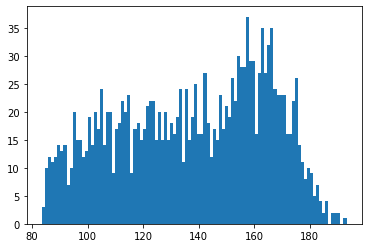

In [7]:
_ = plt.hist(NHANES_child.Height, 100)

## A very simple model: the mode

We would like to come up with a model that will ultimately allow us to accurately predict the height for any child.  One very simple idea might be to just use the mode --- that is, the most common value in the dataset.  

In [8]:
mode_result = scipy.stats.mode(NHANES_child['Height'])
height_mode = mode_result.mode[0]
height_mode

166.5

In this simple model, the predicted height for any child would be 166.5 cm.  

How do we know if this is a good model?  A simple way to assess this would be to ask how far each data point is from its predicted value (i.e., the mode):

In [9]:
error_mode = NHANES_child['Height'] - height_mode
error_mode.mean()

-28.80419869899468

If we look at the average error across children, it's more than 28 cm. That seems like a bad model!  


## A better model: The mean

Let's see what happens if we instead use the arithmetic mean as our model:


In [10]:
height_mean = NHANES_child['Height'].mean()
error_mean = NHANES_child['Height'] - height_mean
error_mean.mean()

-9.983734714169119e-15

This number is essentially zero - and we can indeed prove that the average error for the arithmetic mean must be zero.  Let's look at a histogram of the errors from the mean:



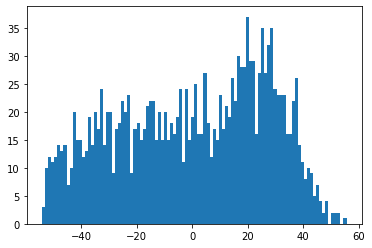

In [11]:
_ = plt.hist(error_mean, 100)

We see that although the average error is now zero, there is still a substantial amount of error across individuals when compared to the mean. We need a way to summarize this error that doesn't allow the positive and negative errors to cancel each other out; one way to accomplish this is by squaring the errors.  If we sum those, we get the *sum of squared errors*:

$$
SSE = \sum_1^N{(y_i - \bar{y})^2}
$$

In order to make this number more interpretable, let's do two things: divide by the number of observations (giving the *mean squared error*) and then taking the square root to put the values back onto the original scale (giving the *root mean squared error*):

$$
RMSE = \sqrt{\frac{\sum_1^N{(y_i - \bar{y})^2}}{N}}
$$


In [12]:
def RMSE(values, estimate):
    """
    return rmse for a set of values and an estimate
    """
    error = values - estimate

    return np.sqrt(error.dot(error)/values.shape[0])

In [13]:
model_RMSE = pd.Series()
model_RMSE['mean'] = RMSE(NHANES_child.Height, height_mean)

model_RMSE['mode']  = RMSE(NHANES_child.Height, height_mode)

model_RMSE



mean    26.911674
mode    39.419793
dtype: float64

Here we see that the RMSE for the mean is substantially less than the mode.  In fact, the mean is guaranteed to have the minimum RMSE for any single value.  We can see this visually by computing the error for many different values, and plotting them:


Text(0.5, 0, 'target value')

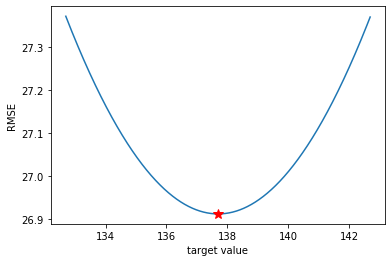

In [23]:
test_values = np.arange(height_mean - 5, height_mean + 5, .01)
rmse_vals = [RMSE(NHANES_child.Height, i) for i in test_values]
plt.plot(test_values, rmse_vals)
plt.plot([height_mean], [model_RMSE['mean']], '*', markersize=10, color='red')
plt.ylabel('RMSE')
plt.xlabel('target value')

The mean minimizes the squared error loss. This is closely related to the L2 norm of the error values, which is the square root of the sum of squared errors, and thus:

$$
RMSE = \frac{||y - \hat{y}||_2}{\sqrt{N}}
$$

Text(0.5, 0, 'target value')

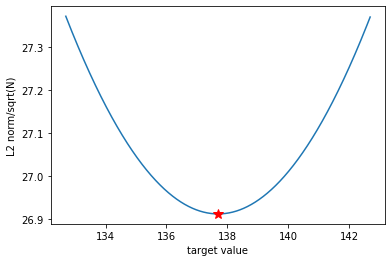

In [47]:
def l2norm_error(data, target):
    """
    return L2 norm, normalized by sqrt of N
    i.e. RMSE
    """

    error = data - target
    return(np.linalg.norm(error)/np.sqrt(error.shape[0]))

l2norm_mean = l2norm_error(NHANES_child.Height, height_mean)
l2norm_vals = [l2norm_error(NHANES_child.Height, i) for i in test_values]
plt.plot(test_values, l2norm_vals)
plt.plot([height_mean], [l2norm_mean], '*', markersize=10, color='red')
plt.ylabel('L2 norm/sqrt(N)')
plt.xlabel('target value')

What if we decided that we wanted to minimize a different loss?  For example, let's say that we instead wanted to minimize the absolute error rather than the squared error:

$$
SAE = \sum_1^N{|y_i - \bar{y}|}
$$

which turns out to be the same as the L1 norm.  Here we will get a slightly different answer - now the mimimum of the loss function falls at the sample *median* (denoted by the red star) rather than the sample mean:


Text(0.5, 0, 'target value')

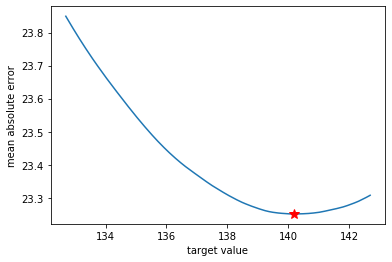

In [26]:
def MAE(data, target):
    abserror = np.abs(data - target)
    return(np.mean(abserror))

height_median = np.median(NHANES_child.Height)
mae_median = MAE(NHANES_child.Height, height_median)
mae_vals = [MAE(NHANES_child.Height, i) for i in test_values]
plt.plot(test_values, mae_vals)
plt.plot([height_median], [mae_median], '*', markersize=10, color='red')
plt.ylabel('mean absolute error')
plt.xlabel('target value')

## Improving our model

The mean doesn't seem like a particularly good model on its own, because it would have us predict the same height for a four-year-old as a teenager. What happens if we instead fit a model that includes height, along with an intercept?  

$$ 
\hat{Height_i} = \beta_1 * age_i + \beta_0
$$

We will return to how we actually fit this model in a later session; for now, we will just use the LinearRegression object from scikit-learn.

slope: [5.4788831]
intercept: 86.10811551847299


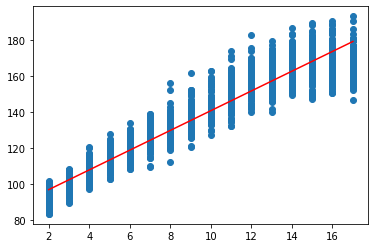

In [154]:
lr = LinearRegression()
lr.fit(NHANES_child[['Age']], NHANES_child['Height'])
print('slope:', lr.coef_)
print('intercept:', lr.intercept_)

def regression_plot(X, y, lr, poly=None):
    """
    given X and y values and an lr object,
    plot the data with the regression line
    desmtx: allows us to specify a more complex design
    """

    plt.scatter(X, y)
    pred_X = np.arange(X.min(), X.max()+.01, .01)
    if poly is None:
        plt.plot(pred_X, lr.predict(pred_X.reshape(-1, 1)), color='red')
    else:
        polyfit = PolynomialFeatures(poly)
        desmtx = polyfit.fit_transform(pred_X.reshape(-1, 1) - np.mean(pred_X))
        plt.plot(pred_X, lr.predict(desmtx), color='red')


regression_plot(NHANES_child['Age'], NHANES_child['Height'], lr)

In [98]:
model_RMSE['age']  = RMSE(NHANES_child['Height'], lr.predict(NHANES_child[['Age']]))
model_RMSE

mean    26.911674
mode    39.419793
age      8.358295
dtype: float64

This is obviously a much better model, right?  

## Overfitting

We generally want our model to fit well, but it's possible for a model to fit *too* well.  To see this, let's generate some data where we know the true generative model for the data (which in this case is a linear model).


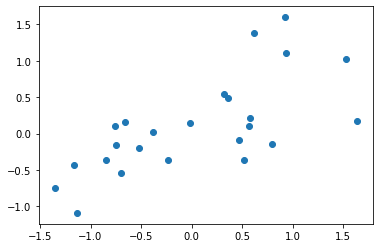

In [130]:
simDf = pd.DataFrame({'X':np.random.randn(24)})
simDf['Y'] = simDf['X']*0.5 + np.random.randn(24)*0.5

plt.scatter(simDf.X, simDf.Y)

First let's look at a linear fit.

linear_orig    0.465141
dtype: float64

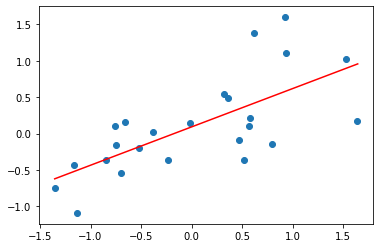

In [166]:
lr = LinearRegression()
## lr.fit wants an Nx1 array for the X variable, and a vector for the Y variable
lr.fit(simDf[['X']], simDf['Y'])

regression_plot(simDf['X'], simDf['Y'], lr)

sim_RMSE = pd.Series()
sim_RMSE['linear_orig'] = RMSE(simDf['Y'], lr.predict(simDf[['X']]))


Now let's fit the same data with a much more complex model: a 5th-order polynomial.  We can use the sklearn function `PolynomialFeatures()` to generate this:

In [167]:
poly_order = 8
polyfit = PolynomialFeatures(poly_order)
# demean the original variable
X = polyfit.fit_transform(simDf[['X']] - simDf['X'].mean())
lr_poly = LinearRegression()
lr_poly.fit(X, simDf['Y'])

sim_RMSE['poly_orig']  = RMSE(simDf['Y'], lr_poly.predict(X))
sim_RMSE

linear_orig    0.465141
poly_orig      0.380489
dtype: float64

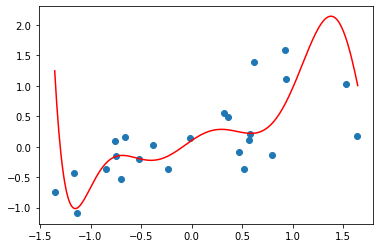

In [164]:
regression_plot(simDf['X'], simDf['Y'], lr_poly,poly=poly_order)

Here we see that the RMSE is much lower than for the linear model - even though we know that the linear model is the right one!  This is because we are *overfitting* the data - that is, our parameter estimates are increasingly reflecting the random noise in the data, rather than the underlying mechanism.  To see this, let's generate another dataset from the same linear function (with different random noise) and see how well our two models (fitted to the previous dataset) generalize to the new data:

In [168]:
simDf['Y_new'] = simDf['X']*0.5 + np.random.randn(24)*0.5

sim_RMSE['poly_new']  = RMSE(simDf['Y_new'], lr_poly.predict(X))
sim_RMSE['linear_new'] = RMSE(simDf['Y_new'], lr.predict(simDf[['X']]))
sim_RMSE

linear_orig    0.465141
poly_orig      0.380489
poly_new       0.637746
linear_new     0.567509
dtype: float64

Now we see that the polynomial model has substantially *higher* RMSE than the linear model on the new data. A more complex model will always fit a particular dataset better than a less complex model, but their ability to predict values for a new dataset will depend on the actual complexity of the underlying process that generates the data.

## Cross-validation

In the previous example, we were able to generate a new dataset from the same underlying process. However, it is usually not feasible for us to generate an entirely new dataset to test our model. Fortunately, there is a way for us to test the generalization ability of our model that works almost as well as testing our model on completely new data: *cross-validation*.  

The idea behind cross-validation is that we split our data into multiple sections (or *folds*), and then iteratively leave out one of the folds, fit the model on the remaining folds (known as the *training* data) and then assess the model fit on the held-out (or *test*) data.  For this to work, it is *absolutely essential* that there is no crosstalk between the training and test folds.  It is also important to have sufficiently large data in order to obtain stable estimates of test accuracy; there is no set number that is "large enough" but an emerging rule of thumb is that it rarely makes sense to perform cross-validation with less than 100 samples.  Otherwise we risk highly variable estimates of accuracy (as shown by Varoquaux in his [Cross-validation failure](https://arxiv.org/abs/1706.07581) paper).

Let's see an example in action.  First we generate some data.

In [246]:
# generate data using 10 random regressors with random parameters
npts = 100
nvars = 20
noise_sd = 5
X = np.random.randn(npts, nvars)
beta = np.zeros((nvars, 1))
beta[3, 0] = 4
y = X.dot(beta) + np.random.randn(npts, 1)*noise_sd
y_new = X.dot(beta) + np.random.randn(npts, 1)*noise_sd


Now let's fit a linear model on the full dataset and assess its fit.  We will assess the fit using the coefficient of variation, aka *R-squared*, which denotes the proportion of variance accounted for in the data.

In [247]:
# first run standard linear regression and compute r-squared

lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.5612672244292995

Also test on new data:

In [248]:
lr.score(X, y_new)

0.31920011653286806

Here we see that our model accounts for a large amount of variance in our sample, but the same model accounts for substantially less variance in a new sample.  Now let's perform cross-validation. We will use the `KFold()` object from sklearn to create the training and test folds.  first let's see a simple version of how this works (from the sklearn documentation):

In [249]:
X_simple = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y_simple = np.array([1, 2, 3, 4])
kf = KFold(n_splits=2)
for train_index, test_index in kf.split(X_simple):
     print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X_simple[train_index], X[test_index]
     y_train, y_test = y_simple[train_index], y[test_index]


TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]


The cross-validation operator returns the indices of the rows in the data that should be assigned to training or test for that particular fold.  Now let's do this on our data, using 10-fold cross-validation.

In [250]:
# create cross-validation operator, 
# shuffling row order to prevent any bias between folds
kf = KFold(n_splits=10, shuffle=True)

# loop through the folds
predicted = np.zeros((npts, 1))
for train_index, test_index in kf.split(X):
    # create separate train and test datasets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # train the model
    lr.fit(X_train, y_train)
    predicted[test_index] = lr.predict(X_test)


# compute r-squared for out-of-sample predictions
r2_score(y, predicted)

0.29651375184353135

Here we see that the goodness of fit for the crossvalidated predictions are very close to those obtained using a new dataset generated from the same mechanism.

## Cross-validation for model selection

So far we have seen how we can use cross-validation to get an accurate estimate of how well our model can generalize to a new sample. We can also use cross-validation to compare different models, since the error on the test data provides us with a measure of how well our model fits new data, which will not be inflated by the complexity of the model.

To see this, let's generate some data where the true underlying function is a third order polynomial, and use cross-validation to find the model with the best generalization performance.


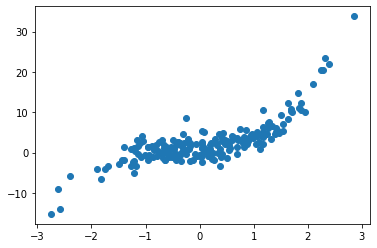

In [309]:
# functions to generate polynomial data for simulation

def poly_generate(x, params):
    """
    generate polynomial function of x given parameters
    x: values to transform
    params: an array of parameters for each polynomial
    """

    powers = np.arange(params.shape[0])
    s = [np.sum(i**powers) for i in x]

    return(np.array(s))

def make_poly_df(npts, params, x_sd = 1, noise_sd = 1):
    X = np.random.randn(npts)*x_sd
    y = poly_generate(X, params) + np.random.randn(npts)*noise_sd
    polyDf = pd.DataFrame({'x':X, 'y':y})
    return(polyDf)

params = np.array([0, 2, -0.4, 1.5])
npts=200
polyDf = make_poly_df(npts, params, noise_sd=2)

plt.scatter(polyDf.x, polyDf.y)

In [326]:
# use crossvalidation to test a range of polynomial model complexities

# create cross-validation operator, 
# shuffling row order to prevent any bias between folds
# use 4 splits here to make things faster
n_splits = 4
kf = KFold(n_splits=n_splits)

# polynomial model orders to test
max_order = 10
poly_orders = np.arange(0, max_order)

X = polyDf[['x']].values
X = X - X.mean()
y = polyDf.y.values

# loop through the folds
predicted = np.zeros((npts, max_order))
errorDf = pd.DataFrame({'order': poly_orders,
                        'train': np.zeros(max_order),
                        'test': np.zeros(max_order)})

for train_index, test_index in kf.split(X):
    # create separate train and test datasets for this fold
    y_train, y_test = y[train_index], y[test_index]

    # loop through the polynomial expansions
    train_errors = []
    for i, poly_order in enumerate(poly_orders):
        polyfit = PolynomialFeatures(poly_order)

        X_train = polyfit.fit_transform(X[train_index])
        X_test = polyfit.fit_transform(X[test_index])

        # train the model
        lr.fit(X_train, y_train)
        errorDf['train'].iloc[i] = errorDf['train'].iloc[i] + r2_score(y_train, lr.predict(X_train))/n_splits
        predicted[test_index, i] = lr.predict(X_test)



Found best test fit for order =  3


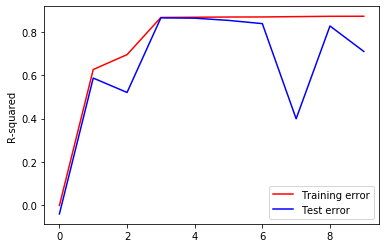

In [327]:
# get prediction errors
for i, poly_order in enumerate(poly_orders):
    errorDf['test'].iloc[i] = r2_score(y, predicted[:,i])

# plot fit indices
plt.plot(errorDf.order, errorDf.train, color='red')
plt.plot(errorDf.order, errorDf.test, color='blue')
plt.legend(['Training error', 'Test error'])
plt.ylabel('R-squared')
print('Found best test fit for order = ', np.argmax(errorDf.test))


Crossvalidation found the correct model order in this case.

You might notice somethign odd: R-squared was actually less than zero for the 0-order model.  How can that happen?  ...